# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM B lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200713.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1036
MOP                         3990
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     139
chondrocyte                   81
early MK                    1665
early erythroid             7534
early osteoblast             291
endosteal fibroblast          5

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
immature B cell          1998
naive B cell             1423
pre B progenitor        14234
pre pro B progenitor     5428
pro B progenitor         5530
dtype: int64

# Change the colours for the B lineage

In [9]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['immature B cell', 'naive B cell', 'pre B progenitor', 'pre pro B progenitor', 'pro B progenitor'], dtype='object')

In [10]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories([
              'pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell'])

In [11]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell'], dtype='object')

In [12]:
adata.obs["cell.labels"].cat.categories[2]

'pre B progenitor'

In [13]:
new_colors = np.empty(len(adata.obs["cell.labels"].cat.categories), dtype=object) 

new_colors[[0]] = '#F59771' # Pre pro B
new_colors[[1]] = '#C8D895' # Pro B
new_colors[[2]] = '#4C79BC' # Pre B
new_colors[[3]] = '#A9479A' # Immature B
new_colors[[4]] = '#F3C3DB' # naive B

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#F59771', '#C8D895', '#4C79BC', '#A9479A', '#F3C3DB'],
      dtype=object)

# Save B cells for cluster monocle run

In [14]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig3a_bcell_raw_20200714.h5ad")

# Pre-process the B cell dataset

In [15]:
adata=sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig3a_bcell_raw_20200714.h5ad")

In [16]:
# normalise count data 
sc.pp.normalize_total(adata)

In [17]:
# log the count data 
sc.pp.log1p(adata)

In [18]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [19]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [20]:
# run pca
sc.tl.pca(adata, n_comps=50)

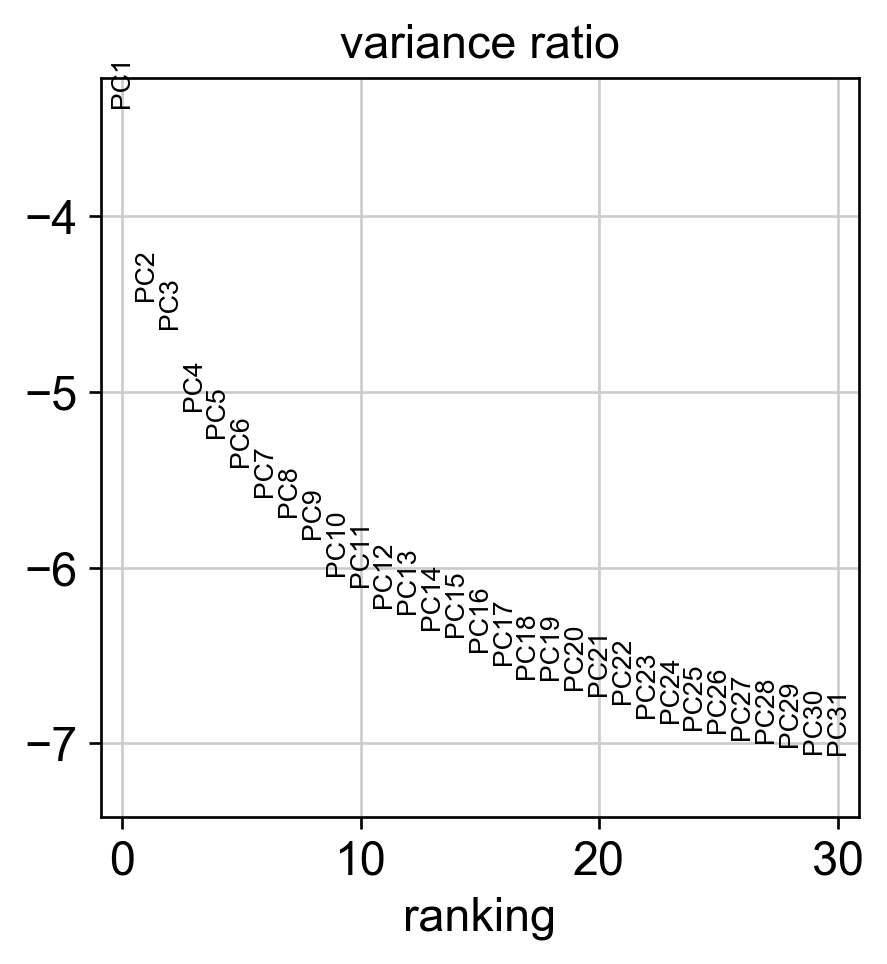

In [21]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [23]:
# run umap
sc.tl.umap(adata) 

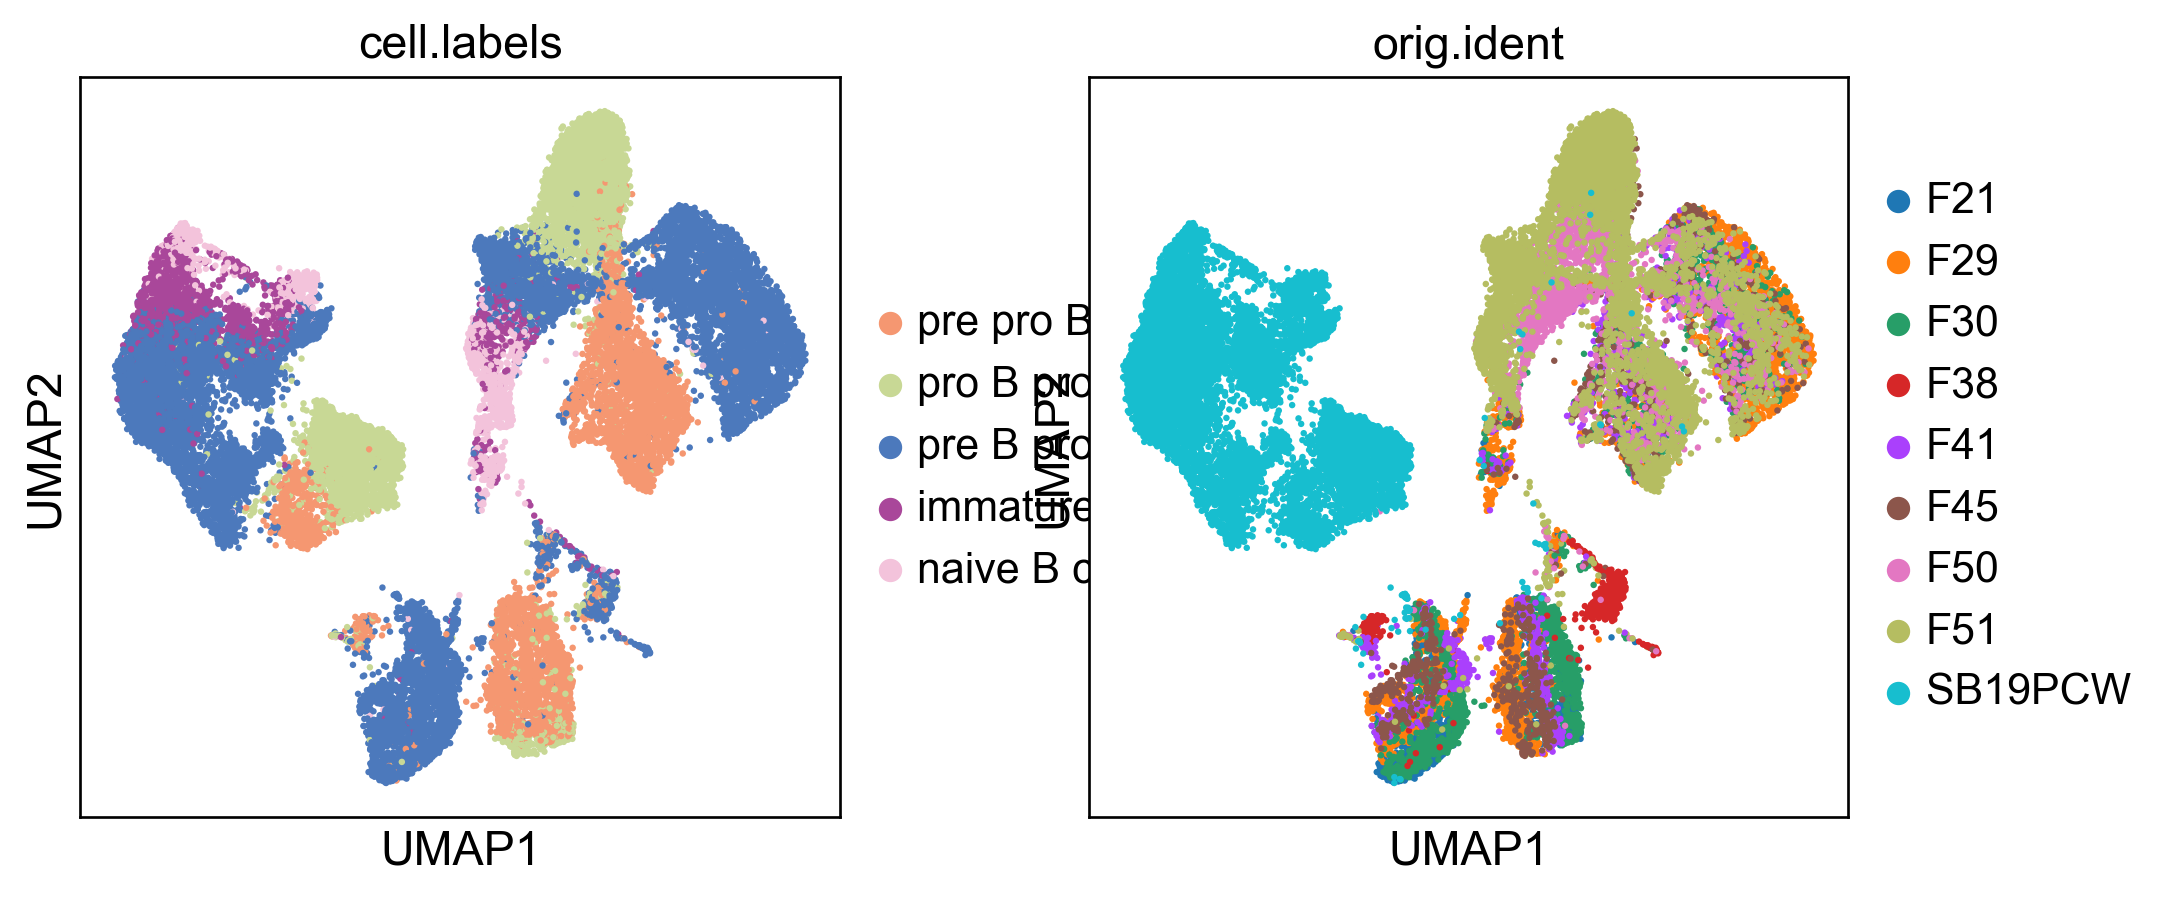

In [24]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [25]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [26]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [27]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [28]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP and FDG

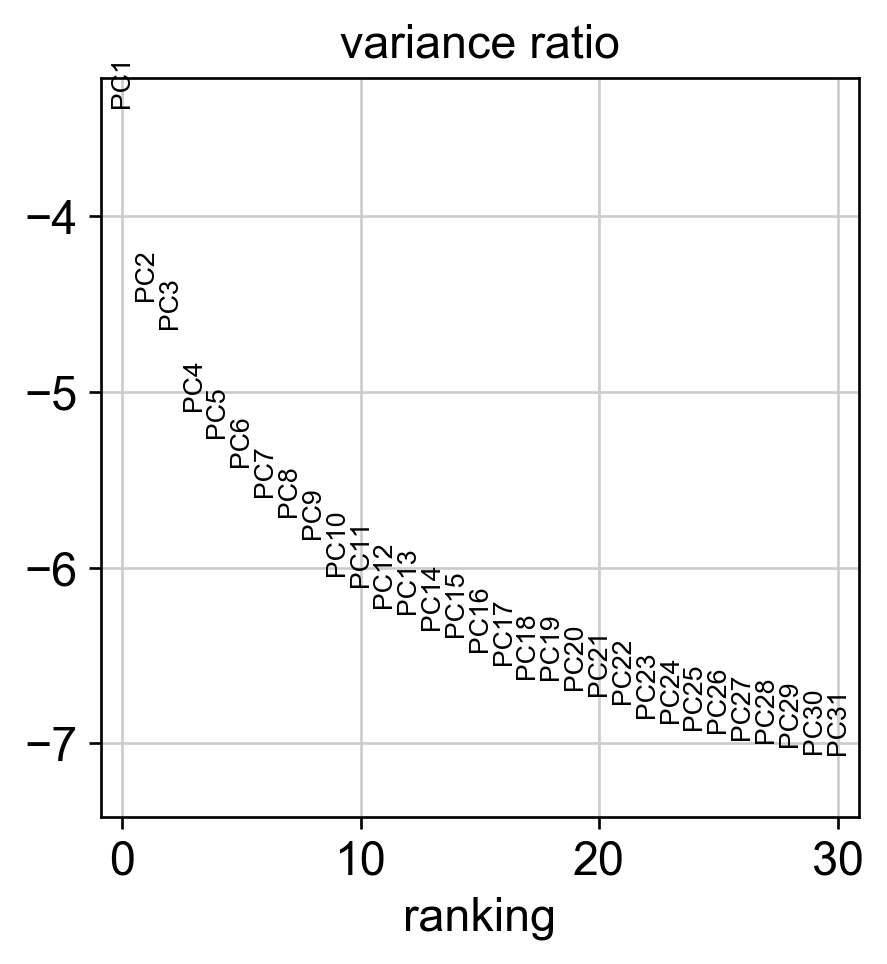

In [29]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [30]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=20) 

In [31]:
# run umap
sc.tl.umap(adata) 

In [32]:
# run fdg 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Add cell cycle info

In [33]:
#Score cell cycle and visualize the effect:
# load file in
cc_genes_file = '/Users/b8058304/Documents/PhD_work/Coding/bm/resources_for_pipelines/cell_cycle_makosco.csv'
cc_genes = pd.read_csv(cc_genes_file, delimiter=',')
# removing na from s and g2m list
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()

In [34]:
y_genes = s_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
s_genes = no_trail 

In [35]:
y_genes = g2m_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
g2m_genes = no_trail 

s_genes_mm = adata.var_names[np.isin(adata.var_names, s_genes)]
g2m_genes_mm = adata.var_names[np.isin(adata.var_names, g2m_genes)]

In [36]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm, g2m_genes=g2m_genes_mm)

In [37]:
adata.obs["phase_combined"] = adata.obs["phase"].replace(["G2M", "S"], ["G2M/S", "G2M/S"])
adata.obs["S/G2M_score_combined"] = (adata.obs["G2M_score"] + adata.obs["S_score"])/2

# Plot UMAP and FDG by celltype/cell-cycle

... storing 'phase' as categorical
... storing 'phase_combined' as categorical


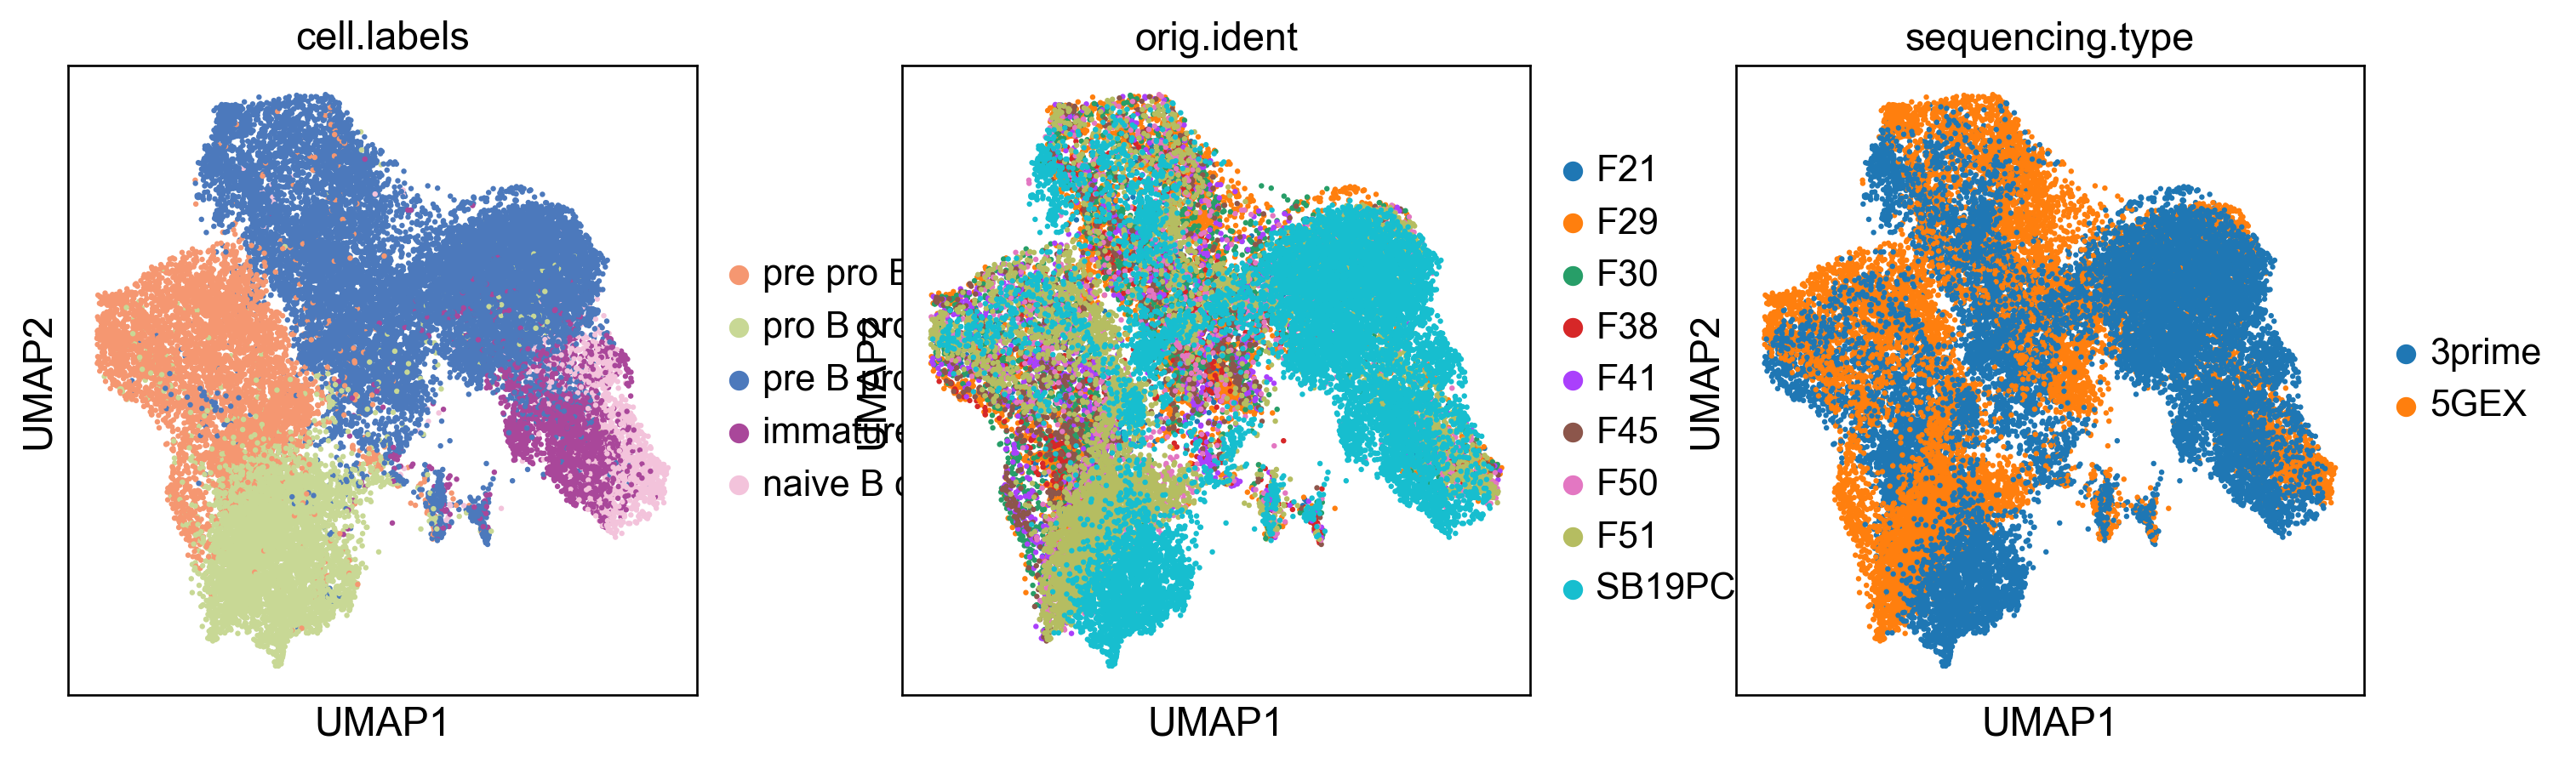

In [38]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], size=15) 

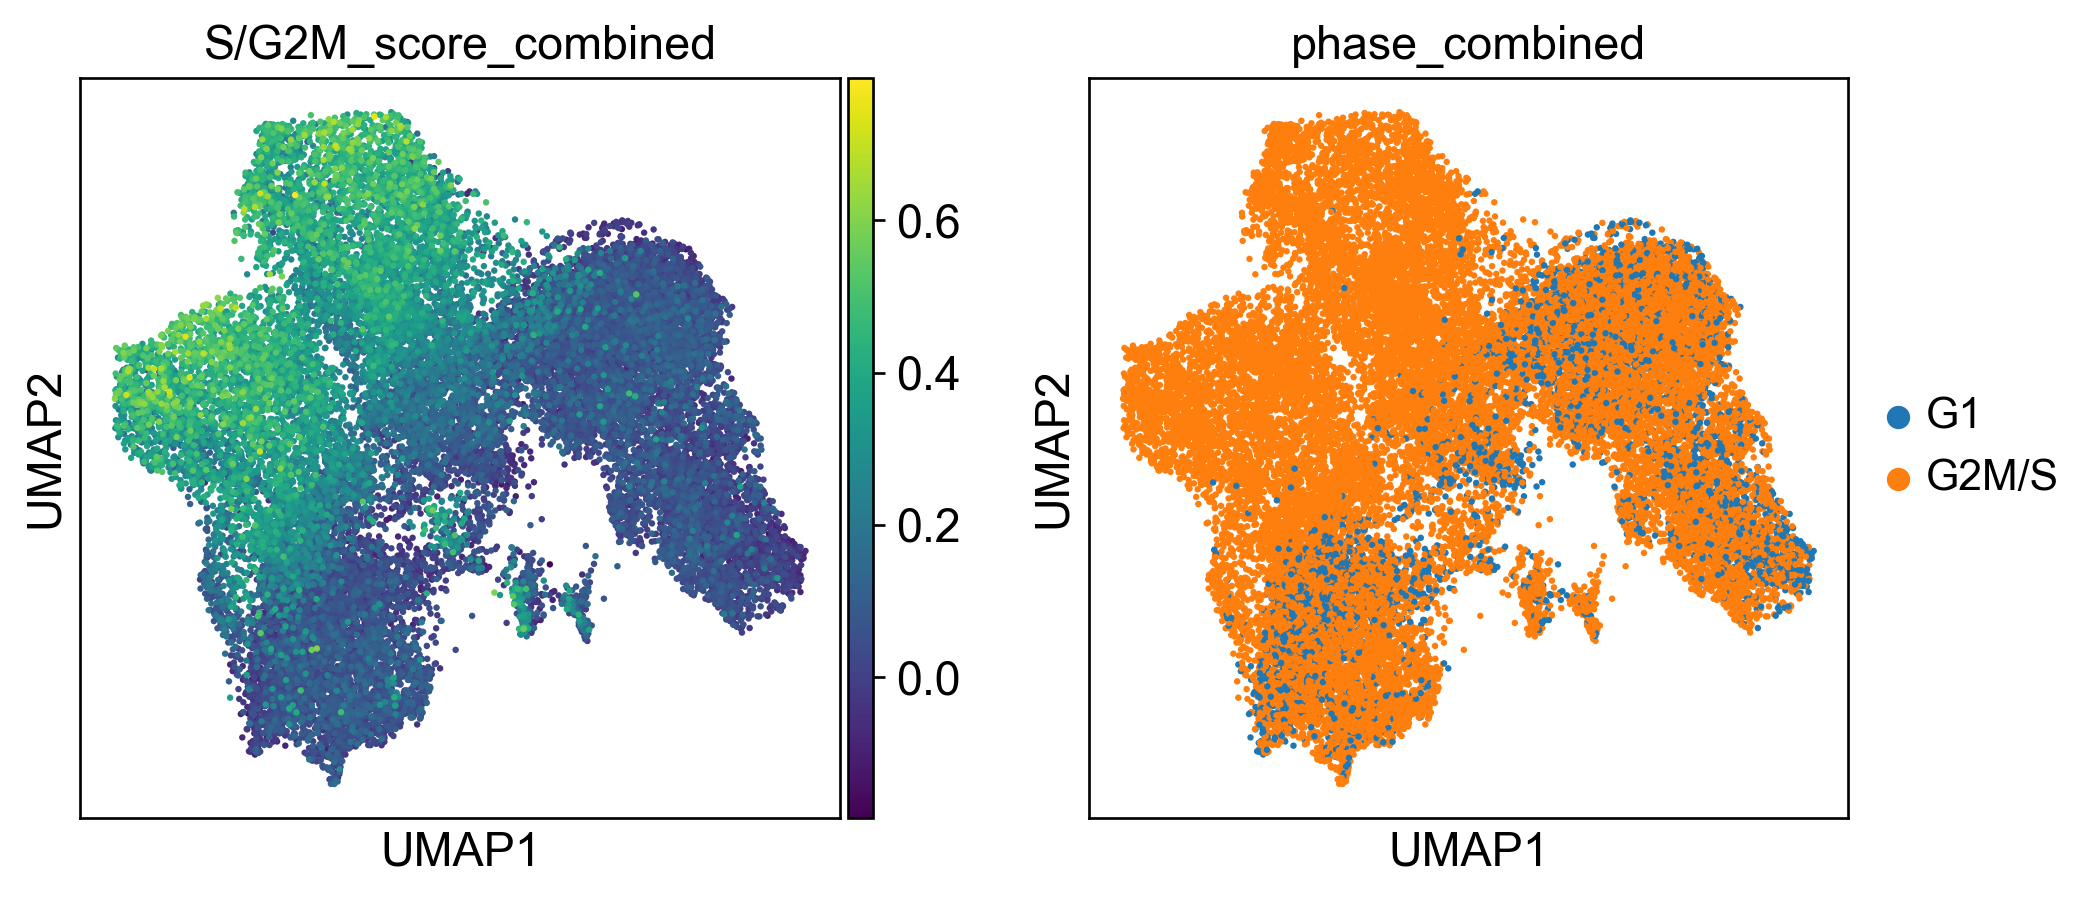

In [39]:
sc.pl.umap(adata, color=['S/G2M_score_combined', 'phase_combined'], size=15)

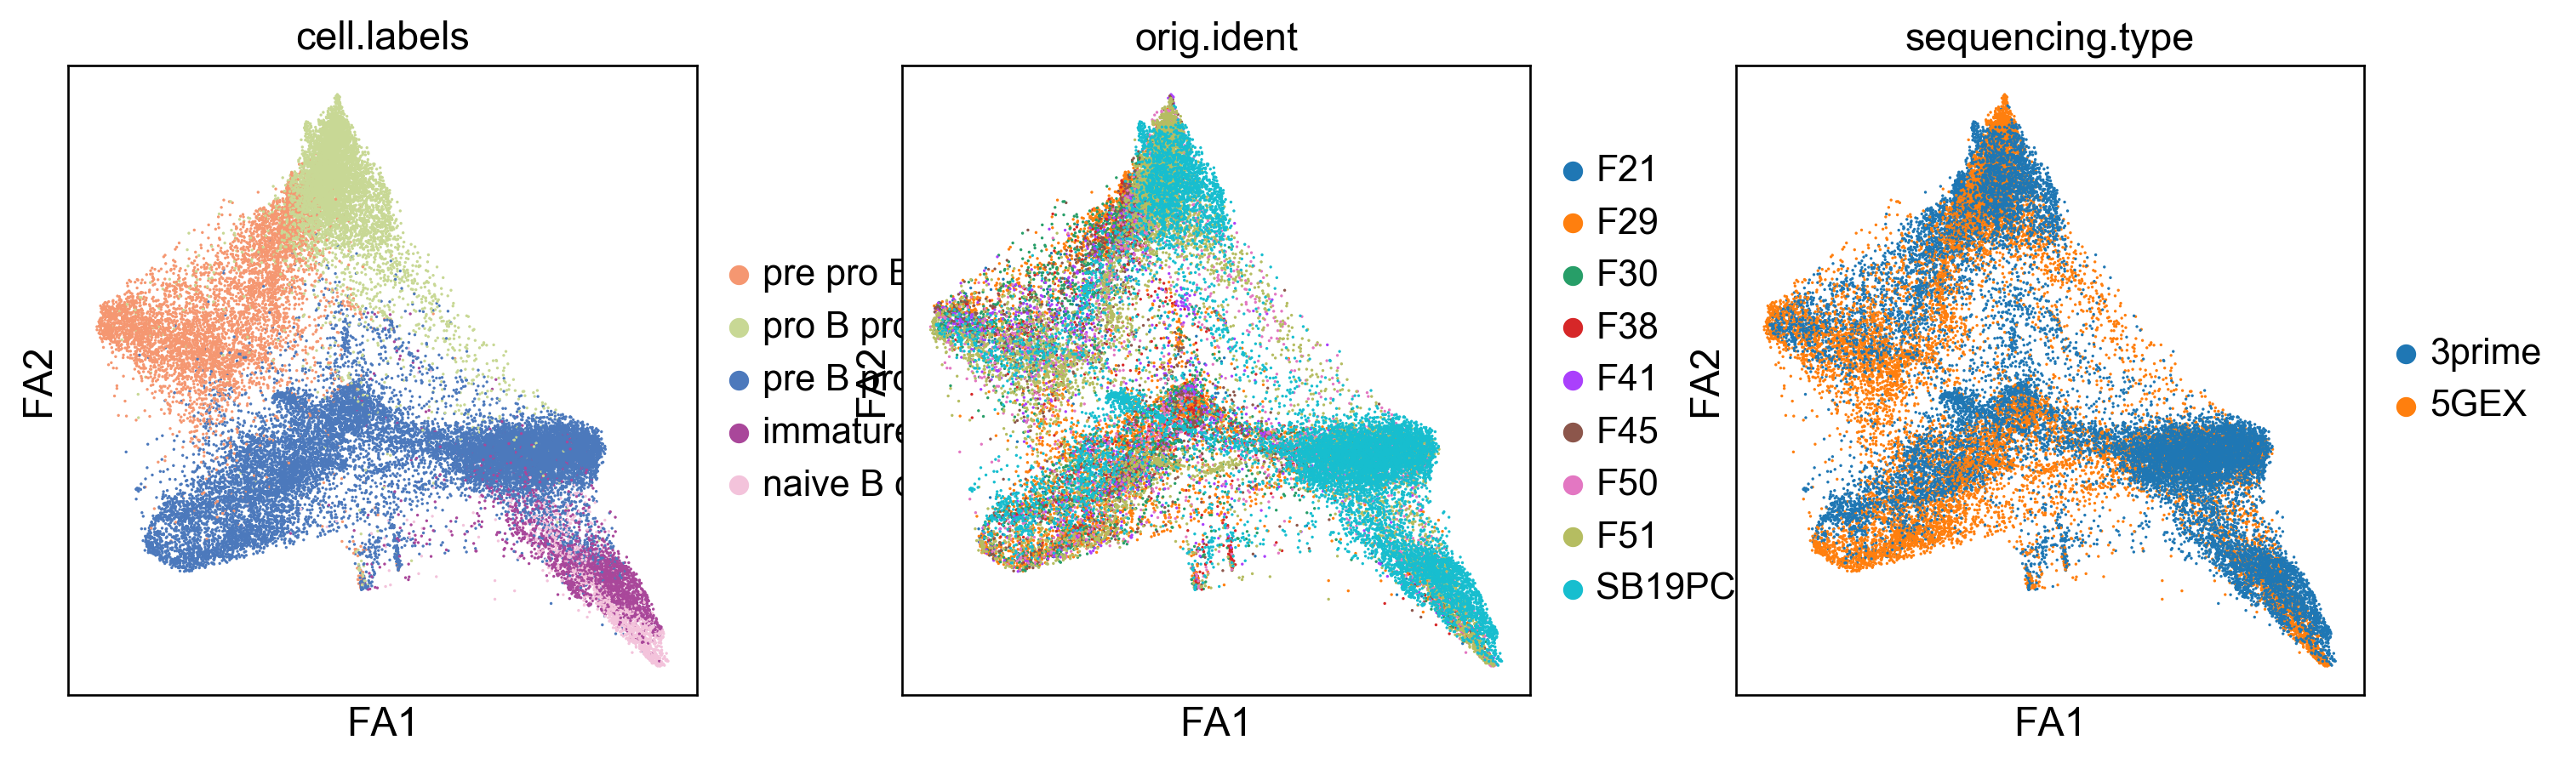

In [40]:
sc.pl.draw_graph(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], layout='fa')

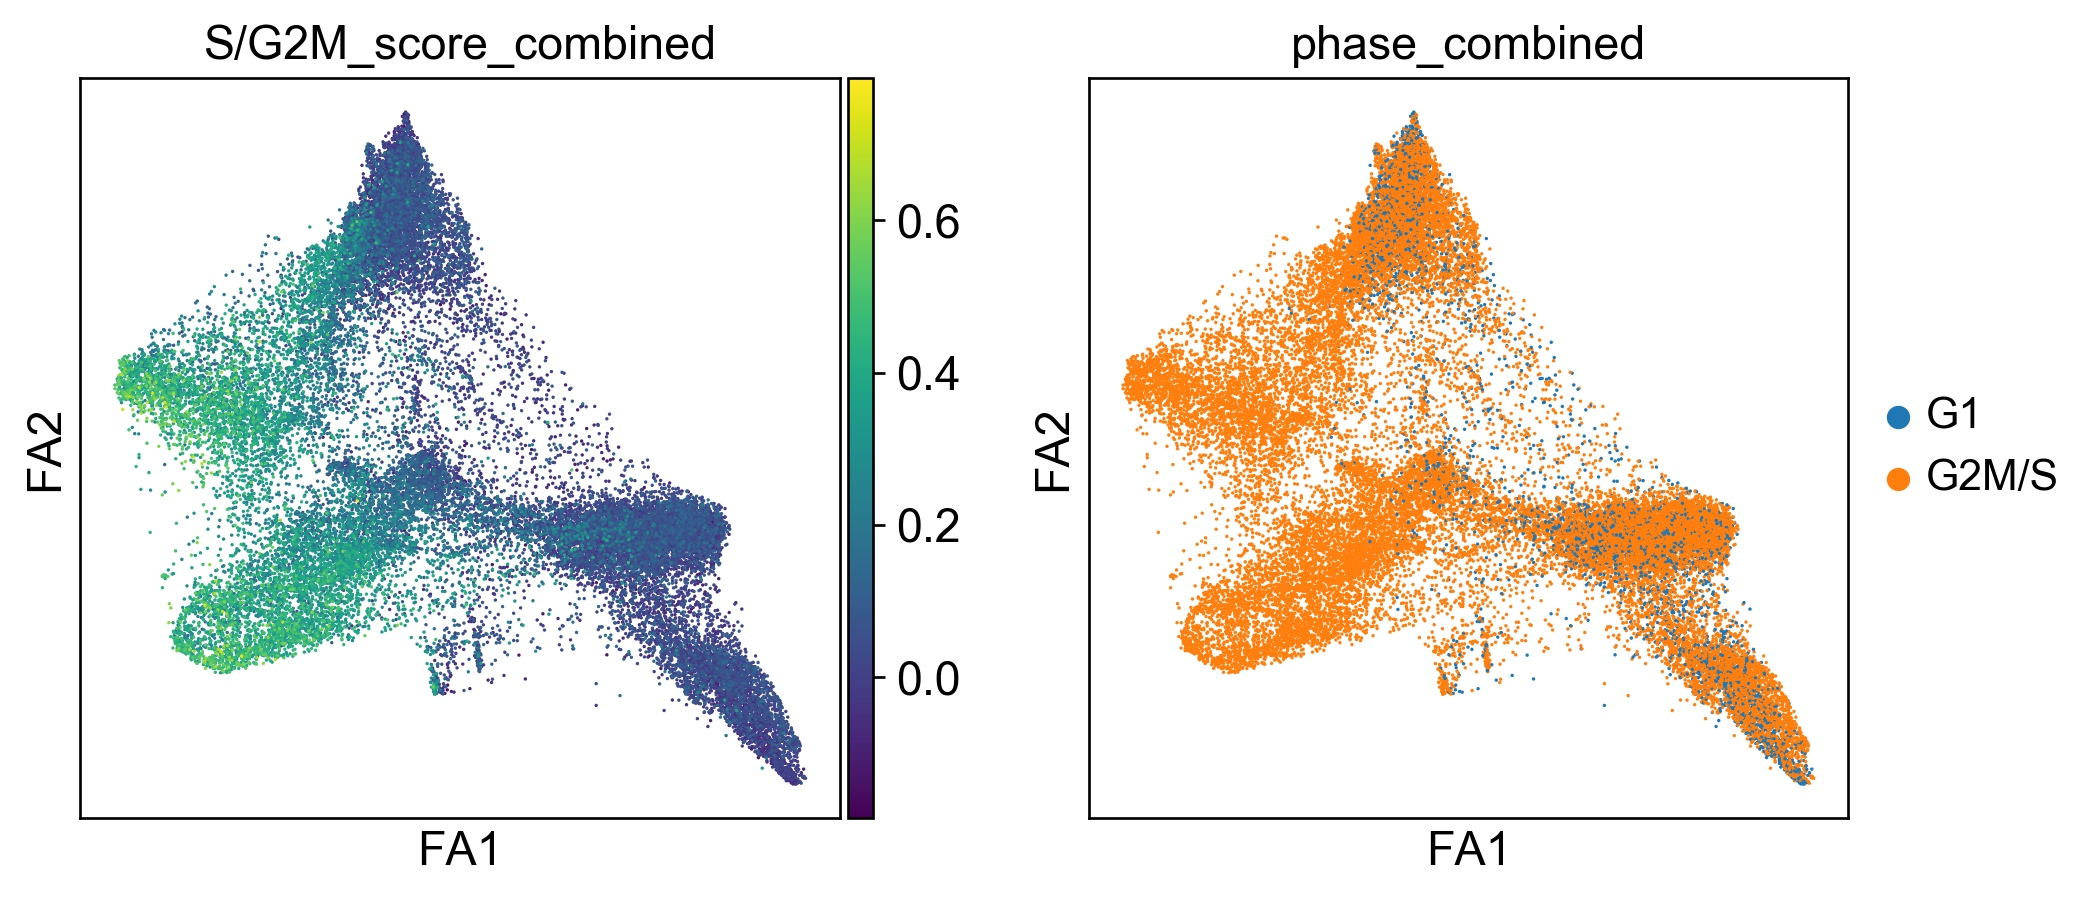

In [41]:
sc.pl.draw_graph(adata, color=[ 'S/G2M_score_combined', 'phase_combined'], layout='fa')

# Save plots

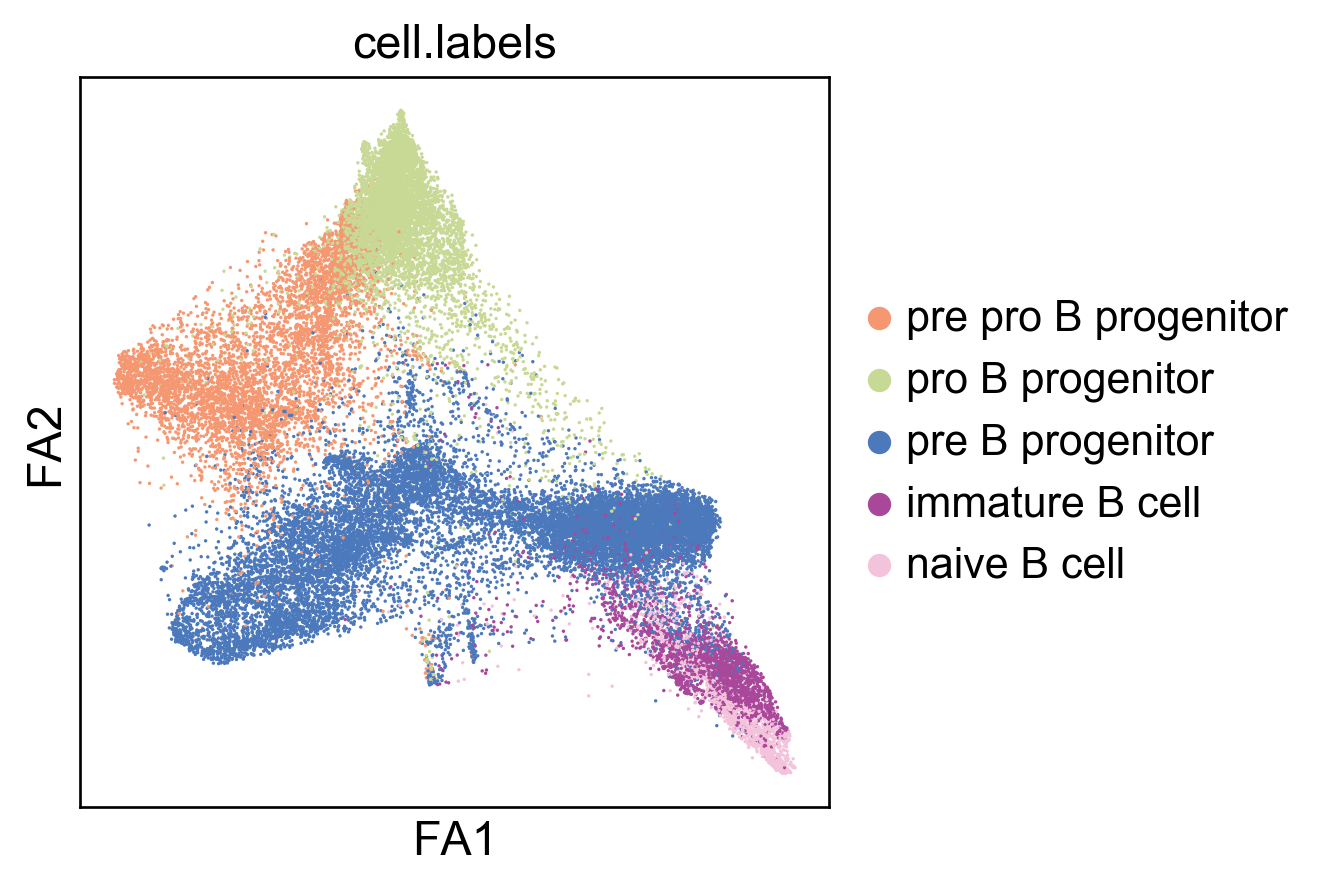

In [42]:
sc.pl.draw_graph(adata, color=['cell.labels'], layout='fa', save="bcell_fdg_celltype_20200714.pdf")

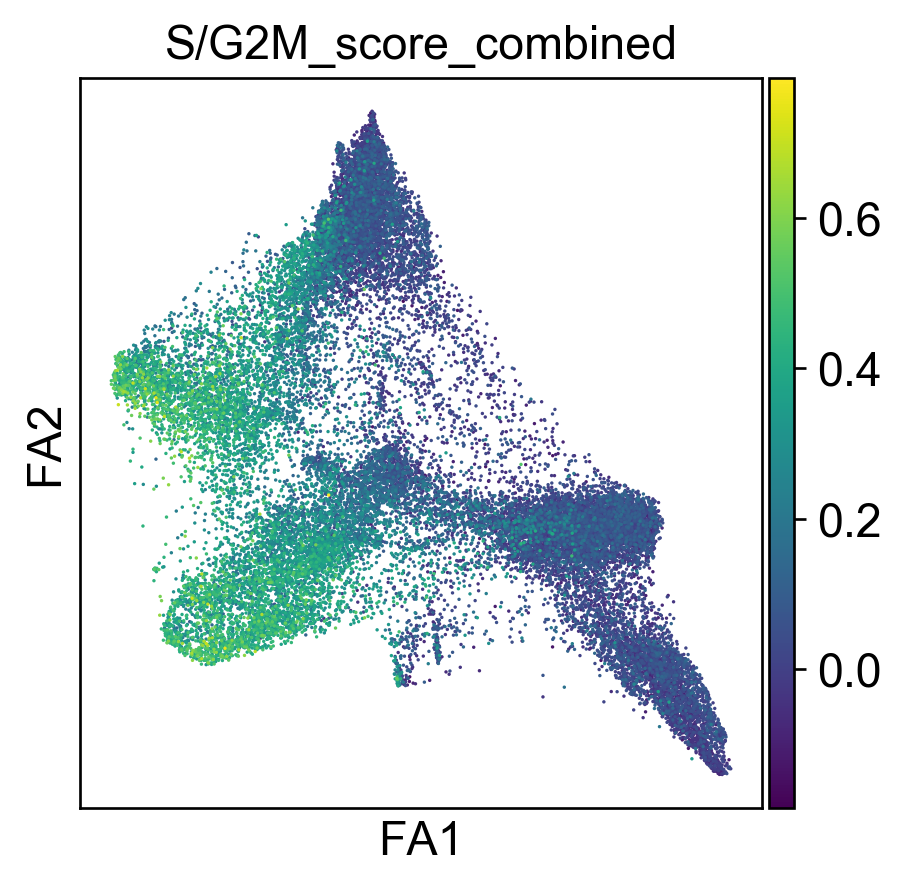

In [43]:
sc.pl.draw_graph(adata, color=['S/G2M_score_combined'], layout='fa', save="bcell_fdg_cellcycle_20200714.pdf")

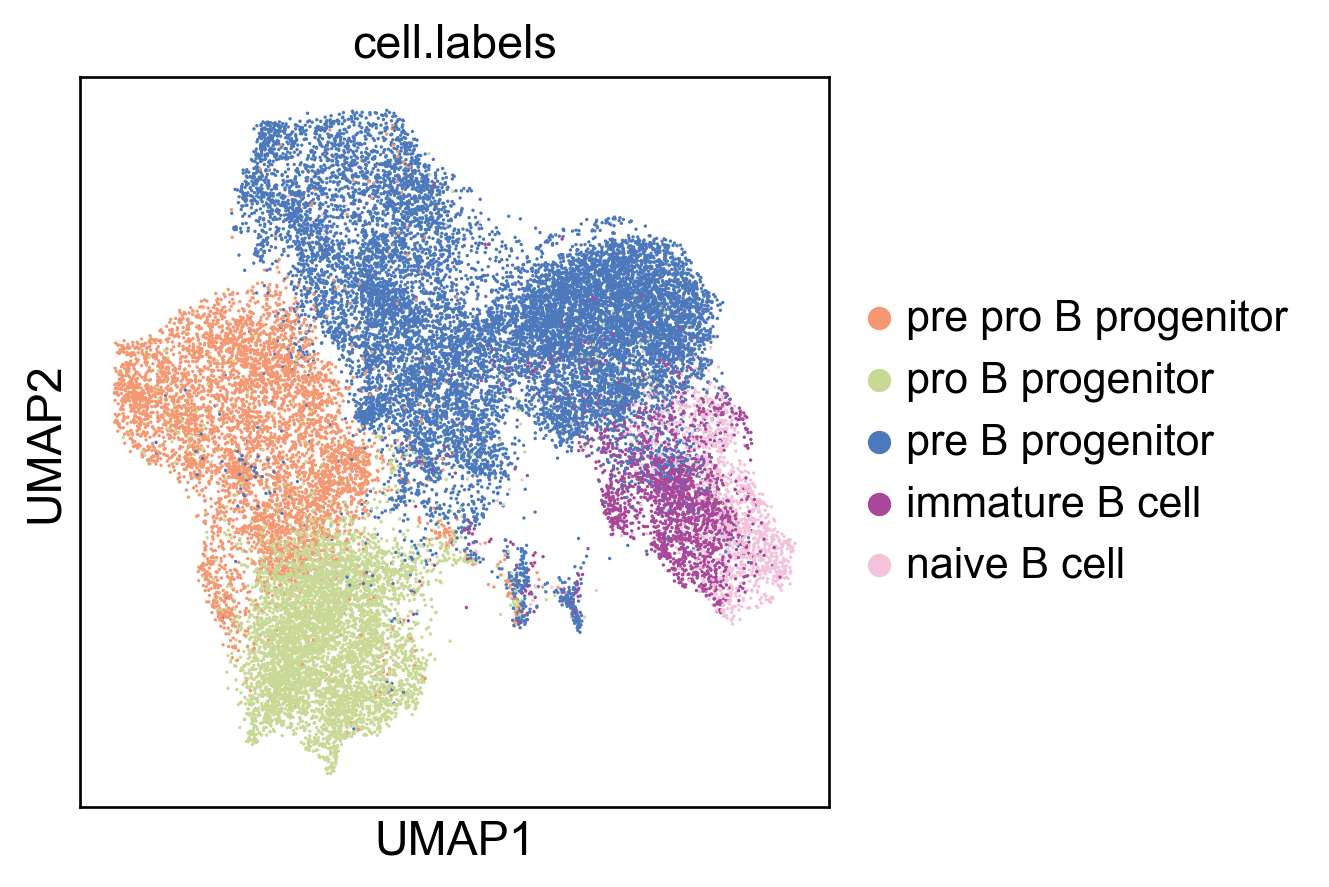

In [44]:
sc.pl.umap(adata, color=['cell.labels'], save="bcell_umap_celltype_20200714.pdf")

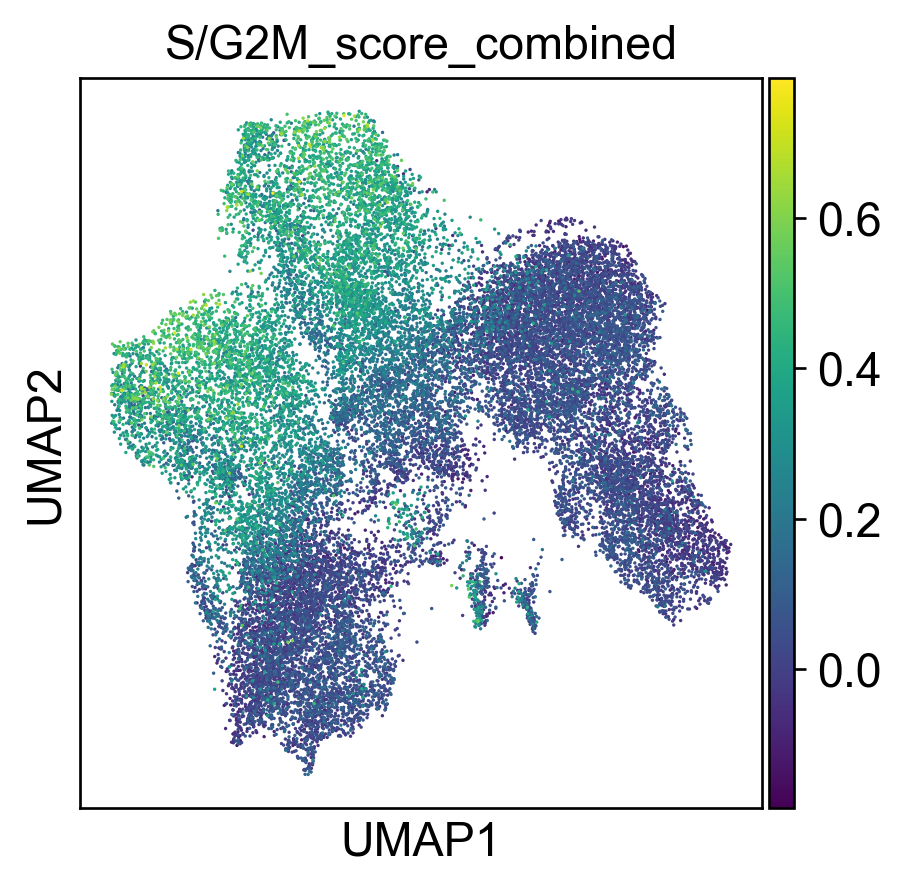

In [45]:
sc.pl.umap(adata, color=['S/G2M_score_combined'], save="bcell_umap_cellcycle_20200714.pdf")

# Save the data

In [46]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [47]:
adata.X

<28613x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 59828587 stored elements in Compressed Sparse Row format>

In [48]:
adata.raw.X

<28613x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 66928538 stored elements in Compressed Sparse Row format>

In [49]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig3a_bcell_dr_20200714.h5ad")